In [223]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings

from prophet import Prophet

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")

In [224]:
df = pd.read_csv("../datasets/10Alytics Hackathon- Fiscal Data.csv")
df.head()

,Country,Indicator,Source,Unit,Currency,Frequency,Country Code,Time,Amount
0,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2007-01-01,-56213
1,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2008-01-01,-67563
2,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2009-01-01,-72379
3,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2010-01-01,-98886
4,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2011-01-01,-134138


In [225]:
df.shape

(23784, 9)

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23784 entries, 0 to 23783
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country       23784 non-null  object
 1   Indicator     23784 non-null  object
 2   Source        23784 non-null  object
 3   Unit          23762 non-null  object
 4   Currency      13281 non-null  object
 5   Frequency     23784 non-null  object
 6   Country Code  23784 non-null  object
 7   Time          23780 non-null  object
 8   Amount        23725 non-null  object
dtypes: object(9)
memory usage: 1.6+ MB


In [227]:
df.describe(include="all")

,Country,Indicator,Source,Unit,Currency,Frequency,Country Code,Time,Amount
count,23784,23784,23784,23762,13281,23784,23784,23780,23725
unique,14,27,28,10,13,3,14,1070,15126
top,South Africa,Inflation Rate,Central Bank of West African States,Million,ZAR,Monthly,ZAF,2021-01-01,12
freq,5108,2879,3295,9964,3086,16850,5108,246,222


### Data Cleaning and Manipulation

In [228]:
df.head()

,Country,Indicator,Source,Unit,Currency,Frequency,Country Code,Time,Amount
0,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2007-01-01,-56213
1,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2008-01-01,-67563
2,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2009-01-01,-72379
3,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2010-01-01,-98886
4,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2011-01-01,-134138


In [229]:
df.isnull().sum()

Country             0
Indicator           0
Source              0
Unit               22
Currency        10503
Frequency           0
Country Code        0
Time                4
Amount             59
dtype: int64

In [230]:
# Convert Amount to numeric
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

In [231]:
df.isnull().sum()

Country             0
Indicator           0
Source              0
Unit               22
Currency        10503
Frequency           0
Country Code        0
Time                4
Amount            502
dtype: int64

In [232]:
# Handle missing values

# 1. Fill units per indicator
df['Unit'] = df.groupby('Indicator')['Unit'].transform(
    lambda x: x.fillna(x.mode()[0] if len(x.mode()) else 'Unknown')
)

# 2. currency
df['Currency'] = df.groupby('Country')['Currency'].transform(
    lambda x: x.fillna(x.mode()[0] if len(x.mode()) else 'Unknown')
)

# 3. Drop missing Time
df = df.dropna(subset=['Time'])

# 4. Interpolate Amount
df['Amount'] = df.groupby(['Country','Indicator'])['Amount'].transform(
    lambda x: x.interpolate()
)

df['Amount'] = df.groupby(['Country','Indicator'])['Amount'].fillna(method='ffill').fillna(method='bfill')



In [233]:
df.isnull().sum()

Country         0
Indicator       0
Source          0
Unit            0
Currency        0
Frequency       0
Country Code    0
Time            0
Amount          0
dtype: int64

In [234]:
df.head()

,Country,Indicator,Source,Unit,Currency,Frequency,Country Code,Time,Amount
0,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2007-01-01,-56213.0
1,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2008-01-01,-67563.0
2,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2009-01-01,-72379.0
3,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2010-01-01,-98886.0
4,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2011-01-01,-134138.0


In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23780 entries, 0 to 23783
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       23780 non-null  object 
 1   Indicator     23780 non-null  object 
 2   Source        23780 non-null  object 
 3   Unit          23780 non-null  object 
 4   Currency      23780 non-null  object 
 5   Frequency     23780 non-null  object 
 6   Country Code  23780 non-null  object 
 7   Time          23780 non-null  object 
 8   Amount        23780 non-null  float64
dtypes: float64(1), object(8)
memory usage: 1.8+ MB


In [236]:
le = LabelEncoder()

def convert_objects_and_get_numeric(df):
    df2 = df.copy()
    le = LabelEncoder()
    numeric_cols = []

    for col in df2.columns:
        # If column is object type → convert
        if df2[col].dtype == 'object':
            df2[col] = le.fit_transform(df2[col].astype(str))

        # After conversion, if numeric → store
        if df2[col].dtype in ['int64', 'float64']:
            numeric_cols.append(col)

    return df2, numeric_cols


df_encoded, cat_col = convert_objects_and_get_numeric(df)
corr_matrix = df_encoded[cat_col].corr()


Text(0.5, 1.0, 'Pearsons Correlations of Columns')

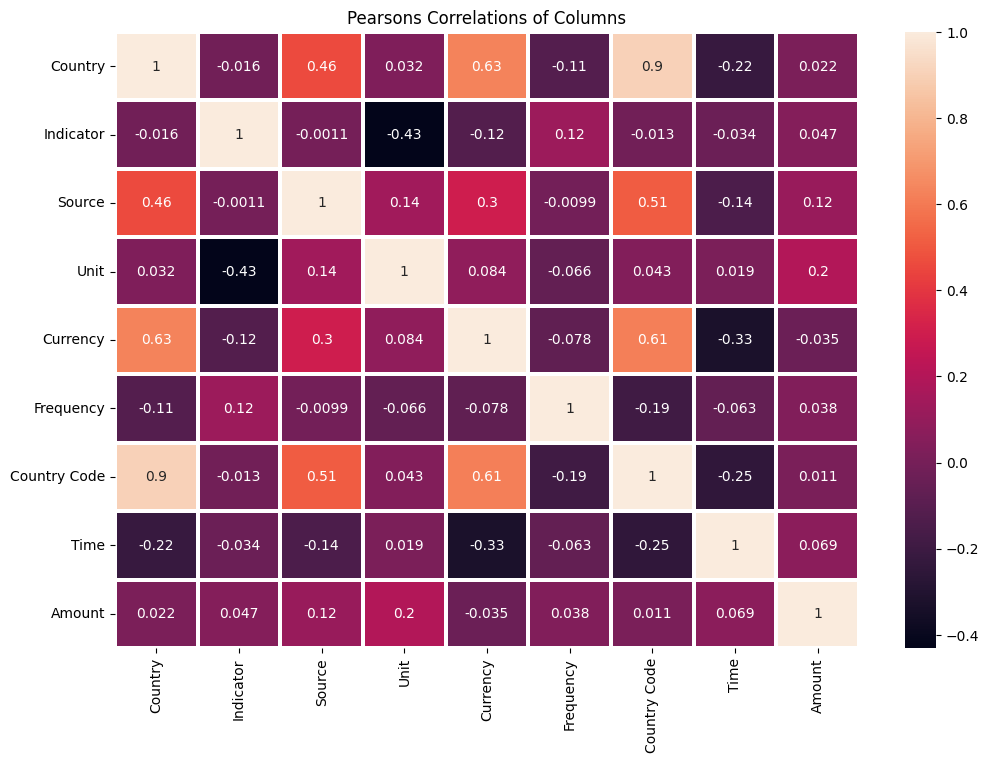

In [237]:
plt.figure(figsize=(12, 8))
sb.heatmap(corr_matrix, linewidth=1.5, annot=True)
plt.title("Pearsons Correlations of Columns", fontsize=(12))

In [238]:
df['Time'] = pd.to_datetime(df['Time'])

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23780 entries, 0 to 23783
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Country       23780 non-null  object        
 1   Indicator     23780 non-null  object        
 2   Source        23780 non-null  object        
 3   Unit          23780 non-null  object        
 4   Currency      23780 non-null  object        
 5   Frequency     23780 non-null  object        
 6   Country Code  23780 non-null  object        
 7   Time          23780 non-null  datetime64[ns]
 8   Amount        23780 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 1.8+ MB


### Trend over time for each Indicator

In [240]:
df['Indicator'].value_counts()

Indicator
Inflation Rate                2879
Consumer Price Index (CPI)    2850
Interest Rate                 2652
Revenue                       1752
Exports                       1611
Imports                       1590
Budget Deficit/Surplus        1417
Government Debt               1121
Food Inflation                1065
Nominal GDP                   1008
Real GDP                      1001
GDP Growth Rate                962
Expenditure                    961
Tax Revenue                    762
Capital Expenditure            663
Value Added Tax (VAT)          376
Population                     323
Unemployment Rate              218
Defence Expenditure            140
Labour Force                   132
Inflation Rate                 124
Health Expenditure              43
GDP per Capita                  41
GDP per Capita                  30
Food Inflation YoY              30
Education Expenditure           19
GDP per capita                  10
Name: count, dtype: int64

In [241]:
indicator_vs_time = df.copy()

In [242]:
indicator_vs_time = indicator_vs_time.set_index('Time')

In [243]:
indicator_vs_time.head()

,Country,Indicator,Source,Unit,Currency,Frequency,Country Code,Amount
Time,,,,,,,,
2007-01-01,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,-56213.0
2008-01-01,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,-67563.0
2009-01-01,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,-72379.0
2010-01-01,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,-98886.0
2011-01-01,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,-134138.0


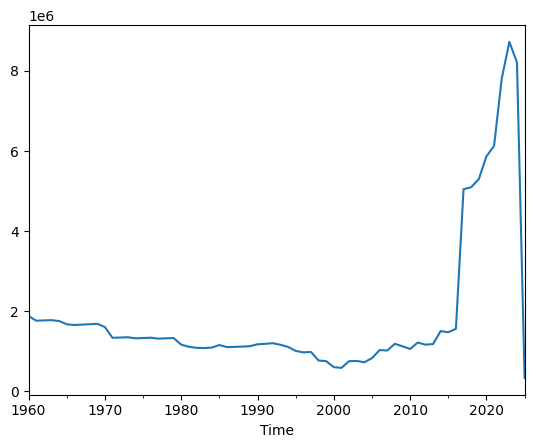

In [244]:
# yearly trend of indicator over time
indicator_vs_time_yr_resampler = indicator_vs_time['Amount'].resample("y").mean().plot()

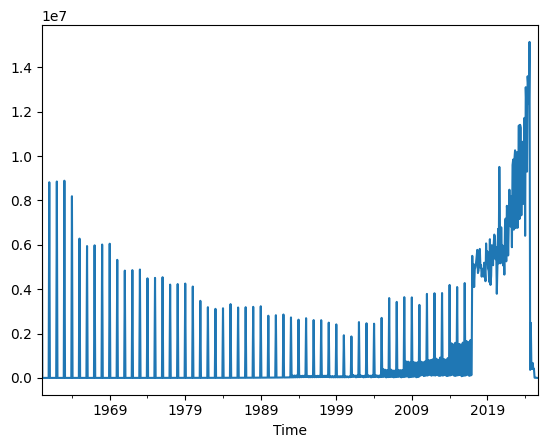

In [245]:
# monthly trend of indicator over time
indicator_vs_time_month_resampler = indicator_vs_time['Amount'].resample("m").mean().plot()

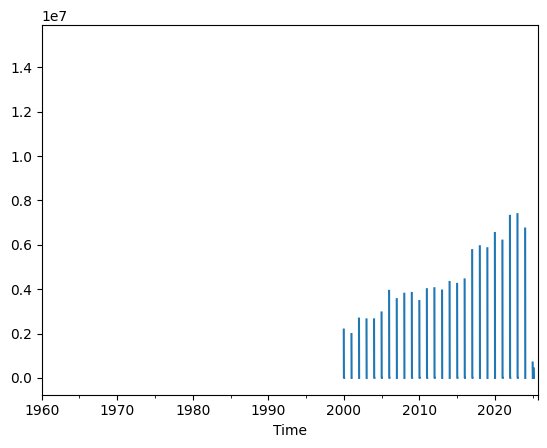

In [246]:
# weekly trend of indicator over time
indicator_vs_time_weekly_resampler = indicator_vs_time['Amount'].resample("w").mean().plot()

In [247]:
df.head()

,Country,Indicator,Source,Unit,Currency,Frequency,Country Code,Time,Amount
0,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2007-01-01,-56213.0
1,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2008-01-01,-67563.0
2,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2009-01-01,-72379.0
3,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2010-01-01,-98886.0
4,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,Million,EGP,Yearly,EGY,2011-01-01,-134138.0


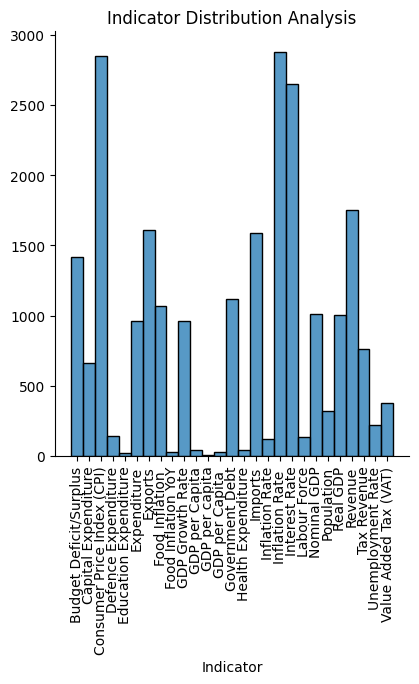

In [248]:
# Indicator Distribution Analysis
sb.displot(df['Indicator'])
plt.title('Indicator Distribution Analysis', fontsize=(12))
plt.xticks(rotation=90)
plt.ylabel(None)
plt.show()

In [249]:
df['Unit'].value_counts()

Unit
Million      9964
%            7875
Points       2548
Billion      1890
Persons       474
points        302
USD           252
Billions      243
Millions      229
Persons/%       3
Name: count, dtype: int64

In [250]:
# Standardizing Unit Labels

df['Unit'] = df['Unit'].str.strip().str.lower()

mapping = {
    'million': 'million',
    'millions': 'million',
    'billion': 'billion',
    'billions': 'billion',
    '%': 'percent',
    'persons': 'persons',
    'points': 'points',
    'usd': 'usd',
    'persons/%': 'mixed'
}

df['Unit'] = df['Unit'].map(mapping)


In [251]:
# Converting the monetary units to common scale

def convert_amount(amount, unit):
    if unit == 'million':
        return amount / 1000     # convert to billions
    if unit == 'billion':
        return amount
    if unit == 'usd':
        return amount / 1e9      # convert USD -> billions
    return amount                # percent, persons, points remain unchanged

df['scaled_amount'] = df.apply(lambda x: convert_amount(x['Amount'], x['Unit']), axis=1)


In [252]:
# Cagtegorizing the Indicators

def categorize(unit):
    if unit in ['million', 'billion', 'usd']:
        return 'monetary'
    if unit == 'percent':
        return 'percentage'
    if unit == 'persons':
        return 'population'
    if unit == 'points':
        return 'index'
    return 'other'

df['Category'] = df['Unit'].apply(categorize)


Text(0.5, 1.0, 'GDP Monetary Analysis Overtime')

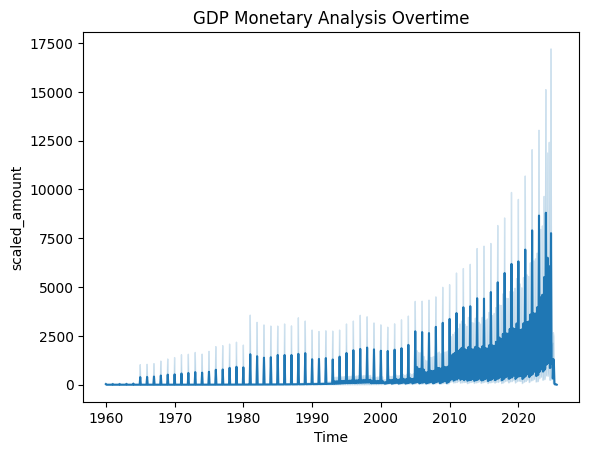

In [253]:
sb.lineplot(data=df[df['Category']=='monetary'], x='Time', y='scaled_amount')
plt.title('GDP Monetary Analysis Overtime', fontsize=(12))

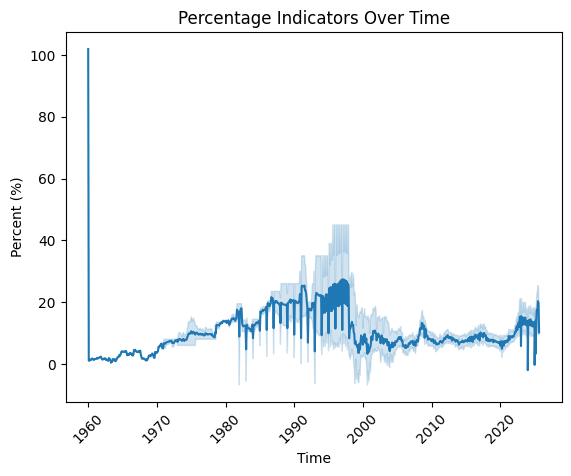

In [254]:
# Percentage Analysis
percent_df = df[df['Category']=='percentage'].copy()
sb.lineplot(
    data=percent_df,
    x='Time',
    y='Amount',
    # hue='Indicator
)
plt.title('Percentage Indicators Over Time')
plt.ylabel('Percent (%)')
plt.xticks(rotation=45);


In [255]:
percentage_summary = percent_df.groupby('Indicator')['Amount'].agg(
    ['mean', 'median', 'std', 'min', 'max']
)
percentage_summary


,mean,median,std,min,max
Indicator,,,,,
Food Inflation,8.437502,7.00,9.663833,-15.55,61.0
Food Inflation YoY,3.440000,4.75,3.684600,-2.00,8.5
GDP Growth Rate,3.955661,4.00,3.661728,-16.42,20.6
Inflation Rate,4.091935,3.80,1.025654,3.00,6.8
Inflation Rate,7.903498,6.01,7.094603,-3.86,101.9
Interest Rate,12.268076,10.00,7.737907,2.00,45.0
Unemployment Rate,20.415102,23.00,8.453054,4.70,35.0


In [256]:
percent_pivot = percent_df.pivot_table(index='Time', columns='Indicator', values='Amount')
percent_pivot.corr()


Indicator,Food Inflation,Food Inflation YoY,GDP Growth Rate,Inflation Rate,Inflation Rate,Interest Rate,Unemployment Rate
Indicator,,,,,,,
Food Inflation,1.000000,0.924373,0.025492,-0.121933,0.812447,-0.396103,-0.411746
Food Inflation YoY,0.924373,1.000000,-0.998926,0.727360,0.951269,-0.999999,-0.875862
GDP Growth Rate,0.025492,-0.998926,1.000000,-0.069362,-0.107726,-0.236909,0.045365
Inflation Rate,-0.121933,0.727360,-0.069362,1.000000,-0.062980,-0.032046,0.450133
Inflation Rate,0.812447,0.951269,-0.107726,-0.062980,1.000000,0.006498,-0.441457
Interest Rate,-0.396103,-0.999999,-0.236909,-0.032046,0.006498,1.000000,-0.042027
Unemployment Rate,-0.411746,-0.875862,0.045365,0.450133,-0.441457,-0.042027,1.000000


Text(0.5, 1.0, 'Pearsons Correlations of Indicators')

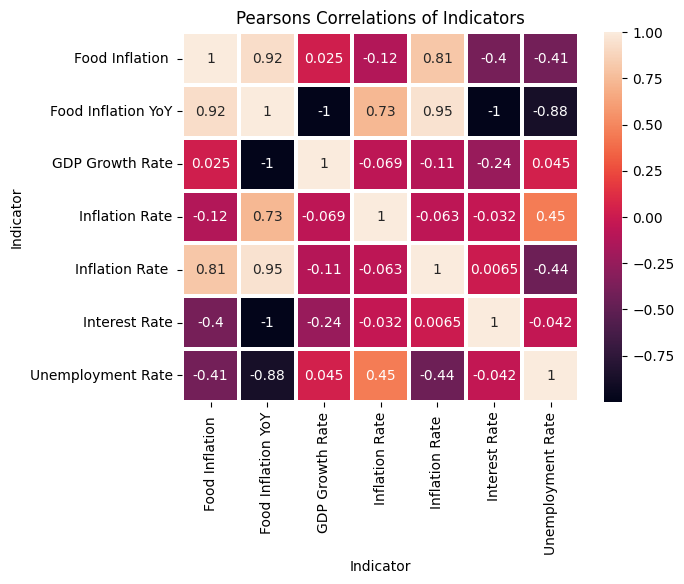

In [257]:
sb.heatmap(percent_pivot.corr(), linewidth=1.5, annot=True)
plt.title("Pearsons Correlations of Indicators", fontsize=(12))

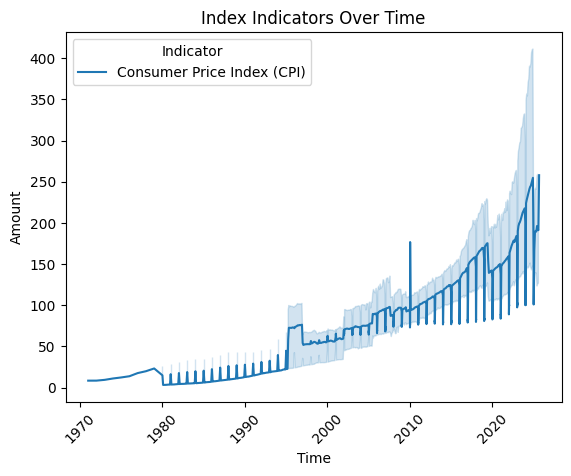

In [258]:

# Index-based indicators are sentiment-driven measures or standardized numeric scores.

index_df = df[df['Category']=="index"].copy()

sb.lineplot(
    data=index_df,
    x='Time',
    y='Amount',
    hue='Indicator'
)
plt.title('Index Indicators Over Time')
plt.xticks(rotation=45);


In [259]:
# Detect Periods of Stress or Expansion
index_df['signal'] = index_df['Amount'].apply(lambda x: 'Expansion' if x >= 50 else 'Contraction')


In [260]:
index_df.head()

,Country,Indicator,Source,Unit,Currency,Frequency,Country Code,Time,Amount,scaled_amount,Category,signal
2080,Algeria,Consumer Price Index (CPI),Bank of Algeria,points,USD,Monthly,DZA,2002-01-01,101.74,101.74,index,Expansion
2081,Algeria,Consumer Price Index (CPI),Bank of Algeria,points,USD,Monthly,DZA,2002-02-01,102.16,102.16,index,Expansion
2082,Algeria,Consumer Price Index (CPI),Bank of Algeria,points,USD,Monthly,DZA,2002-03-01,101.94,101.94,index,Expansion
2083,Algeria,Consumer Price Index (CPI),Bank of Algeria,points,USD,Monthly,DZA,2002-04-01,101.34,101.34,index,Expansion
2084,Algeria,Consumer Price Index (CPI),Bank of Algeria,points,USD,Monthly,DZA,2002-05-01,100.61,100.61,index,Expansion


In [261]:
df[df['Category']=="mixed"]

,Country,Indicator,Source,Unit,Currency,Frequency,Country Code,Time,Amount,scaled_amount,Category


In [262]:
df[df['Category']=="percentage"].head();

In [263]:
df['Category'].value_counts()

Category
monetary      12578
percentage     7875
index          2850
population      474
other             3
Name: count, dtype: int64

In [264]:
df.head()

,Country,Indicator,Source,Unit,Currency,Frequency,Country Code,Time,Amount,scaled_amount,Category
0,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,million,EGP,Yearly,EGY,2007-01-01,-56213.0,-56.213,monetary
1,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,million,EGP,Yearly,EGY,2008-01-01,-67563.0,-67.563,monetary
2,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,million,EGP,Yearly,EGY,2009-01-01,-72379.0,-72.379,monetary
3,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,million,EGP,Yearly,EGY,2010-01-01,-98886.0,-98.886,monetary
4,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,million,EGP,Yearly,EGY,2011-01-01,-134138.0,-134.138,monetary


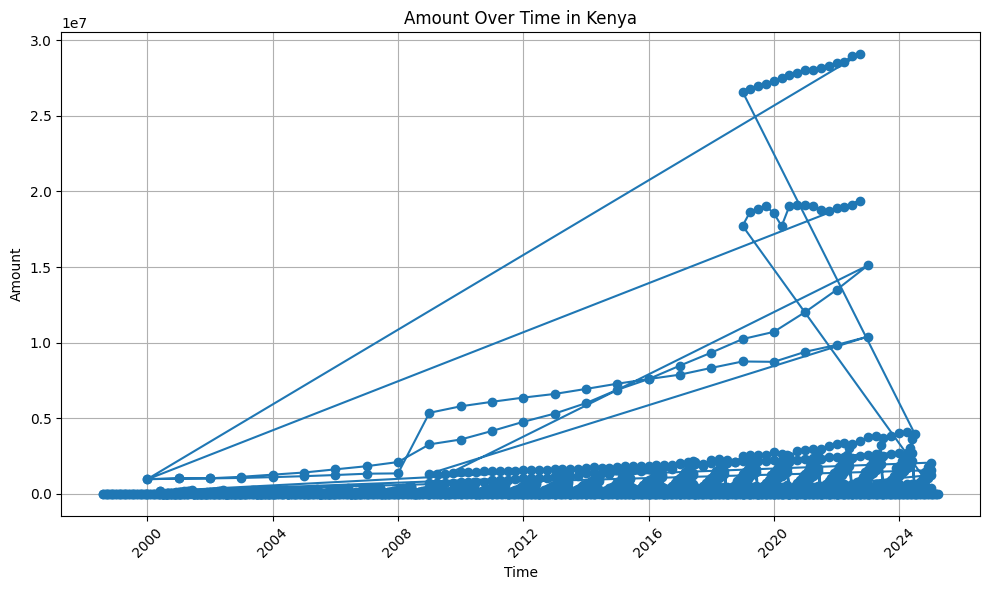

In [265]:
country_group = df.groupby('Country')
get_country = country_group.get_group('Kenya')
get_country = get_country.set_index('Time')


# Plot the 'Amount' column over time
plt.figure(figsize=(10,6))
plt.plot(get_country.index, get_country['Amount'], marker='o', linestyle='-')
plt.title('Amount Over Time in Kenya')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.grid(True)
plt.xticks(rotation=45)  # rotate x-axis labels if Time is date
plt.tight_layout()
plt.show()

In [266]:
df['Time'].max()

Timestamp('2025-09-01 00:00:00')

In [267]:
df['Time'].min()

Timestamp('1960-01-01 00:00:00')

In [268]:
df.head()

,Country,Indicator,Source,Unit,Currency,Frequency,Country Code,Time,Amount,scaled_amount,Category
0,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,million,EGP,Yearly,EGY,2007-01-01,-56213.0,-56.213,monetary
1,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,million,EGP,Yearly,EGY,2008-01-01,-67563.0,-67.563,monetary
2,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,million,EGP,Yearly,EGY,2009-01-01,-72379.0,-72.379,monetary
3,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,million,EGP,Yearly,EGY,2010-01-01,-98886.0,-98.886,monetary
4,Egypt,Budget Deficit/Surplus,Central Bank of Egypt,million,EGP,Yearly,EGY,2011-01-01,-134138.0,-134.138,monetary


In [277]:
model_prophet = Prophet()
# model_prophet.add_regressor('Country')

In [278]:

get_country.reset_index()

# Ensure Time is datetime
df['Time'] = pd.to_datetime(df['Time'])

# Chronological split: train <= 2012, test >= 2013
df_data_train = df[df['Time'].dt.year <= 2012]
df_data_test = df[df['Time'].dt.year >= 2013]

# Prepare for Prophet: rename columns
df_train_prophet = df_data_train.rename(columns={"Time": "ds", "Amount": "y"})
df_test_prophet = df_data_test.rename(columns={"Time": "ds", "Amount": "y"})

In [279]:
model_prophet.fit(df_train_prophet)

18:54:43 - cmdstanpy - INFO - Chain [1] start processing
18:54:46 - cmdstanpy - INFO - Chain [1] done processing


In [280]:
df_future = model_prophet.make_future_dataframe(periods=200, freq='MS', )
display(df_future)

,ds
0,1960-01-01
1,1960-02-01
2,1960-03-01
3,1960-04-01
4,1960-05-01
...,...
974,2029-04-01
975,2029-05-01
976,2029-06-01
977,2029-07-01


In [281]:
forecast_prophet = model_prophet.predict(df_future)
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
974,2029-04-01,1672153.0,-8435555.0,11083576.0
975,2029-05-01,1255940.0,-8622753.0,11787117.0
976,2029-06-01,1255233.0,-8302112.0,12430623.0
977,2029-07-01,1632168.0,-7773106.0,12106507.0
978,2029-08-01,1192177.0,-8802300.0,10636245.0


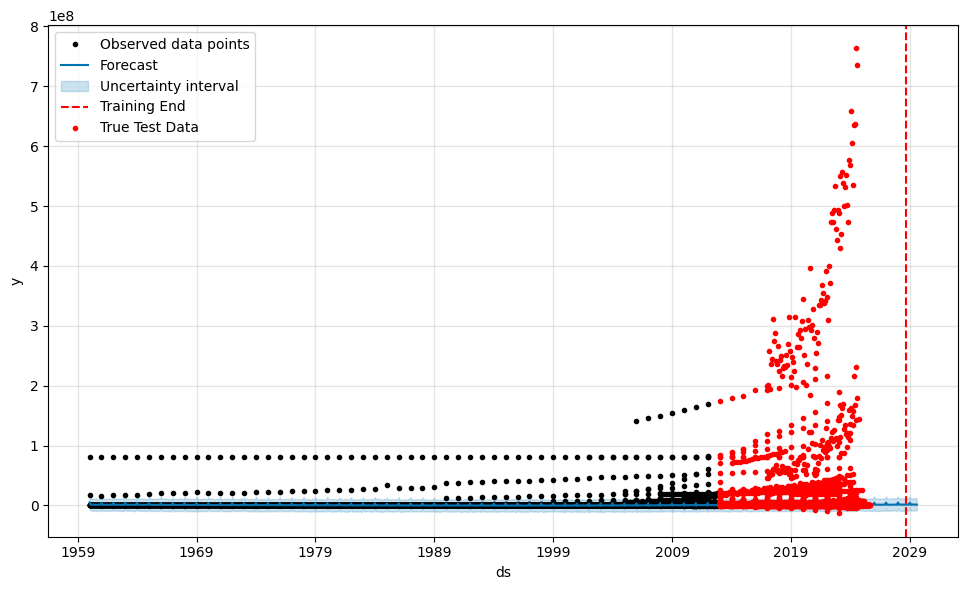

In [282]:
# plot the time series 
forecast_plot = model_prophet.plot(forecast_prophet)

# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = forecast_prophet['ds'].iloc[-12]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# plot true test data for the period after the red line
df_data_test_plot = df_data_test.reset_index()  # Time as column
plt.plot(df_data_test_plot['Time'], df_data_test_plot['Amount'], 'ro', markersize=3, label='True Test Data')

# show the legend to distinguish between the lines
plt.legend()
# plt.show()

In [283]:
from joblib import dump, load

# Save
dump(model_prophet, 'prophet_model.joblib')

# Load
loaded_model = load('prophet_model.joblib')
